# Installation
Install required packages for deepCOLOR analysis

In [ ]:
! pip install deepcolor imgaug==0.2.5

# Preprocessing data
Although deepCOLOR estimate the spatial distribution of single cells based on raw count matrix of single cell and spatail transcriptomes, it requires normalized expression for downstream analysis such as DEG detection. Also, we exclude lowly expressed cells and spots from folowing analysis. In this tutorial, we use pre-processed dataset of squamous cartinoma from [Ji et al. 2020](https://www.sciencedirect.com/science/article/pii/S0092867420306723?via%3Dihub).


In [3]:
! mkdir -p data/tutorial/
! wget -O data/tutorial/scc_sc.h5ad https://www.dropbox.com/s/cx2wx67cpqpu167/scc_sc.h5ad?dl=0
! wget -O data/tutorial/scc_sp.h5ad https://www.dropbox.com/s/as4v1yh4yrezrc6/scc_sp.h5ad?dl=0
import torch
import scanpy as sc
import numpy as np
np.random.seed(1)
torch.manual_seed(1)

In [23]:
sc_adata = sc.read_h5ad('data/tutorial/scc_sc.h5ad')
sp_adata = sc.read_h5ad('data/tutorial/scc_sp.h5ad')

You need to align gene names for both sinlge cell and spatial `AnnData` objects. We also excluede genes lowly expressed.

In [24]:
import numpy as np
sc_adata = sc_adata[:, sc_adata.layers['count'].toarray().sum(axis=0) > 10]
sp_adata = sp_adata[:, sp_adata.layers['count'].toarray().sum(axis=0) > 10]
common_genes = np.intersect1d(sc_adata.var_names, sp_adata.var_names)
sc_adata = sc_adata[:, common_genes]
sp_adata = sp_adata[:, common_genes]

# Estimate Spatial distribution
Estimation of spatial distribution is conduted for each singel cell. For this process, we strongly recommend you to conduct the caluculation in GPU availabel environments.

In [25]:
# conduct spatial estimation
import deepcolor
import importlib
importlib.reload(deepcolor)
sc_adata, sp_adata = deepcolor.estimate_spatial_distribution(sc_adata, sp_adata, param_save_path='data/tutorial/opt_params.pt', first_epoch=500, second_epoch=500)


Loss: 15761.6572265625
Start first opt
loss at epoch 0 is 14228.947265625
loss at epoch 10 is 12343.0185546875
loss at epoch 20 is 11043.0380859375
loss at epoch 30 is 10304.349609375
loss at epoch 40 is 9866.2666015625
loss at epoch 50 is 9583.560546875
loss at epoch 60 is 9384.0888671875
loss at epoch 70 is 9230.7578125
loss at epoch 80 is 9087.322265625
loss at epoch 90 is 8979.146484375
loss at epoch 100 is 8888.1865234375
loss at epoch 110 is 8807.9755859375
loss at epoch 120 is 8738.755859375
loss at epoch 130 is 8677.3427734375
loss at epoch 140 is 8617.3212890625
loss at epoch 150 is 8569.28125
loss at epoch 160 is 8526.8701171875
loss at epoch 170 is 8485.912109375
loss at epoch 180 is 8451.341796875
loss at epoch 190 is 8416.1298828125
loss at epoch 200 is 8384.6728515625
loss at epoch 210 is 8353.6142578125
loss at epoch 220 is 8323.42578125
loss at epoch 230 is 8294.5341796875
loss at epoch 240 is 8263.7646484375
loss at epoch 250 is 8230.5927734375
loss at epoch 260 is 819

Here, we will display imputed expression patterns, combining estiamted spatial distribution of single cells with its expression profiles.

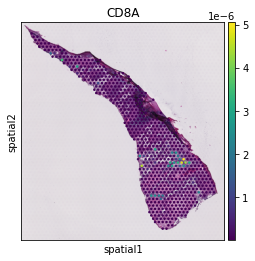

In [28]:
from matplotlib import pyplot as plt
sp_adata = deepcolor.calculate_imputed_spatial_expression(sc_adata, sp_adata)
sc.pl.spatial(sp_adata, color="CD8A", layer='imputed_exp')


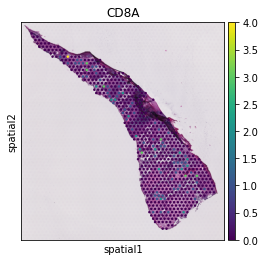

In [29]:
sc.pl.spatial(sp_adata, color="CD8A", layer='count')

The first panel represents the imputed CD8A expression, while the second panel represents original expression. It is shown that imputed expression is more smooth than original one.

While deepCOLOR estimate spatial distributions in single cell level, it can estimate the spatial distribution of spcified cell popluation by aggregating the distribution of belongin cells.

some of cluster names in `cluster_label` is overlapped with `sp_adata.obs.columns`


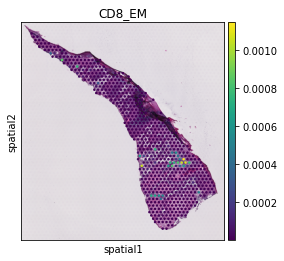

In [30]:
sp_adata = deepcolor.calculate_clusterwise_distribution(sc_adata, sp_adata, 'level3_celltype')
sc.pl.spatial(sp_adata, color='CD8_EM')

# Colocalization based ligand receptor interaction

Using ligand-target regulatory potentianl derived from NicheNet ([Browaeys et al. 2020](https://www.nature.com/articles/s41592-019-0667-5)), we can estimate the ligand activity between spatially proximal cells.

In [31]:
! wget -O data/tutorial/ligand_target_df.csv https://www.dropbox.com/s/2z7ogbks4504iya/ligand_target_df.csv?dl=0
import pandas as pd
importlib.reload(deepcolor)
lt_df = pd.read_csv('data/tutorial/ligand_target_df.csv', index_col=0)
fig, coexp_cc_df = deepcolor.calculate_proximal_cell_communications(sc_adata, 'level1_celltype', lt_df, ["PDC", "CD1C", "ASDC", "MDSC", "Mac", "MDSC"], celltype_sample_num=500, ntop_genes=4000, each_display_num=3, role="sender", edge_thresh=1)
fig

/home/tiisaishima/mambaforge/envs/deepcolor/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning:

Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['P2_Tumor_TTCCCAGGTCTCTTTA-1', 'P2_Tumor_TTCCCAGGTCTCTTTA-2', 'P2_Tumor_TTCCCAGGTCTCTTTA-3', 'P2_Tumor_TTCCCAGGTCTCTTTA-4', 'P7_Tumor_ATGCGATGTCCAAGTT-1']

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


# Colocalization based clustering
Clustering cell pairs with high coloalization scores, we can obtain cell population pairs characterized by its colocalization.

/home/tiisaishima/packages/deepcolor/src/deepcolor/workflow.py:306: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/tiisaishima/packages/deepcolor/src/deepcolor/workflow.py:307: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/tiisaishima/mambaforge/envs/deepcolor/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning:

Initializing view as actual.

Trying to set attribute `.obs` of view, copying.
... storing 'large_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'coloc_cluster' as categorical


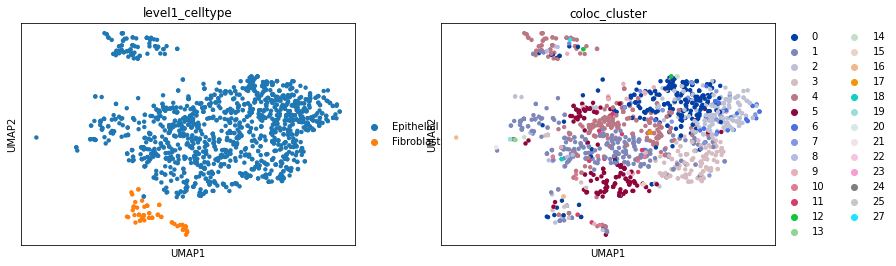

In [32]:
dual_adata = deepcolor.analyze_pair_cluster(sc_adata, sp_adata, ["Epithelial"], ["Fibroblast"], "level1_celltype", max_pair_num=30000)
sc_adata.obs['coloc_cluster'] = 'None'
sc_adata.obs.loc[dual_adata.obs.cell1_obsname, 'coloc_cluster'] = dual_adata.obs.leiden.values
sc_adata.obs.loc[dual_adata.obs.cell2_obsname, 'coloc_cluster'] = dual_adata.obs.leiden.values
pair_adata = sc_adata[sc_adata.obs['coloc_cluster'] != 'None']
sc.pl.umap(pair_adata, color=['level1_celltype', 'coloc_cluster'])